In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from src.config import load_config
from src.logger import logger
from src.data import Fred_Data
config = load_config()
fred_data = Fred_Data(api_key=fred_api_key,series_ids=config['series_ids'])
fred_data = fred_data.fetch_data()
df = fred_data.get_dataframe()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


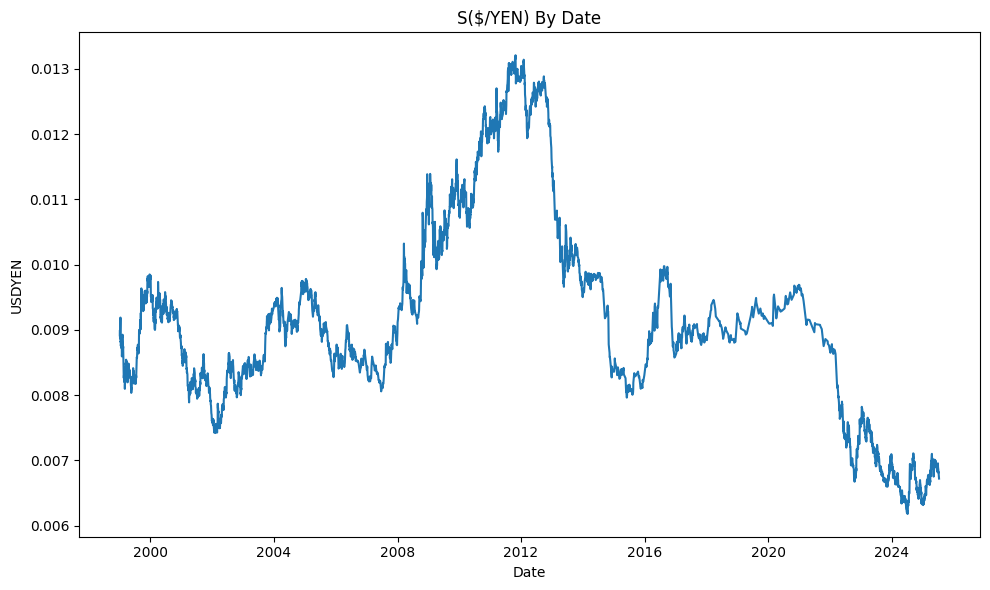

In [2]:
# changing the S(YEN/USD) to a direct quote

df['USDYEN'] = 1 / df['YENUSD']
df = df['USDYEN']
df.drop_duplicates(inplace=True)


df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDYEN',data=df)
plt.title("S($/YEN) By Date")
plt.savefig("images/spotrate-USDYEN.png")
plt.tight_layout()
plt.show()




In [3]:

training = df.iloc[:,0:1].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 256
num_layers = 1 
output_size = 1

model = GRU(input_size, hidden_size, num_layers, output_size)

model = GRU(input_size,hidden_size,num_layers,output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')




C:\Users\katsa\AppData\Local\Temp\ipykernel_18508\3687205254.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_18508\3687205254.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4178; Test RSME: 0.08106
Epoch: 1; train_RSEM: 0.365; Test RSME: 0.129
Epoch: 2; train_RSEM: 0.3133; Test RSME: 0.1803
Epoch: 3; train_RSEM: 0.2638; Test RSME: 0.2353
Epoch: 4; train_RSEM: 0.2214; Test RSME: 0.2947
Epoch: 5; train_RSEM: 0.1976; Test RSME: 0.3581
Epoch: 6; train_RSEM: 0.2043; Test RSME: 0.4191
Epoch: 7; train_RSEM: 0.2266; Test RSME: 0.4589
Epoch: 8; train_RSEM: 0.2348; Test RSME: 0.4657
Epoch: 9; train_RSEM: 0.2236; Test RSME: 0.4467
Epoch: 10; train_RSEM: 0.2025; Test RSME: 0.4132
Epoch: 11; train_RSEM: 0.1819; Test RSME: 0.3741
Epoch: 12; train_RSEM: 0.1681; Test RSME: 0.3352
Epoch: 13; train_RSEM: 0.1627; Test RSME: 0.2995
Epoch: 14; train_RSEM: 0.163; Test RSME: 0.2689
Epoch: 15; train_RSEM: 0.165; Test RSME: 0.2439
Epoch: 16; train_RSEM: 0.1656; Test RSME: 0.2246
Epoch: 17; train_RSEM: 0.1632; Test RSME: 0.2108
Epoch: 18; train_RSEM: 0.1568; Test RSME: 0.2018
Epoch: 19; train_RSEM: 0.1466; Test RSME: 0.1972
Epoch: 20; train_RSEM: 0.1334; Te

In [4]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length: -1]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

         Date  Actual Spot Rate  Predicted Spot Rate
0  2023-10-20          0.006673             0.006690
1  2023-10-23          0.006676             0.006685
2  2023-10-24          0.006674             0.006683
3  2023-10-25          0.006669             0.006682
4  2023-10-26          0.006647             0.006681
5  2023-10-27          0.006684             0.006676
6  2023-10-30          0.006711             0.006676
7  2023-10-31          0.006602             0.006683
8  2023-11-01          0.006624             0.006675
9  2023-11-02          0.006645             0.006664
10 2023-11-03          0.006695             0.006656
11 2023-11-07          0.006646             0.006660
12 2023-11-08          0.006633             0.006662
13 2023-11-09          0.006621             0.006659
14 2023-11-13          0.006598             0.006652
15 2023-11-14          0.006633             0.006643
16 2023-11-15          0.006619             0.006637
17 2023-11-16          0.006641             0.

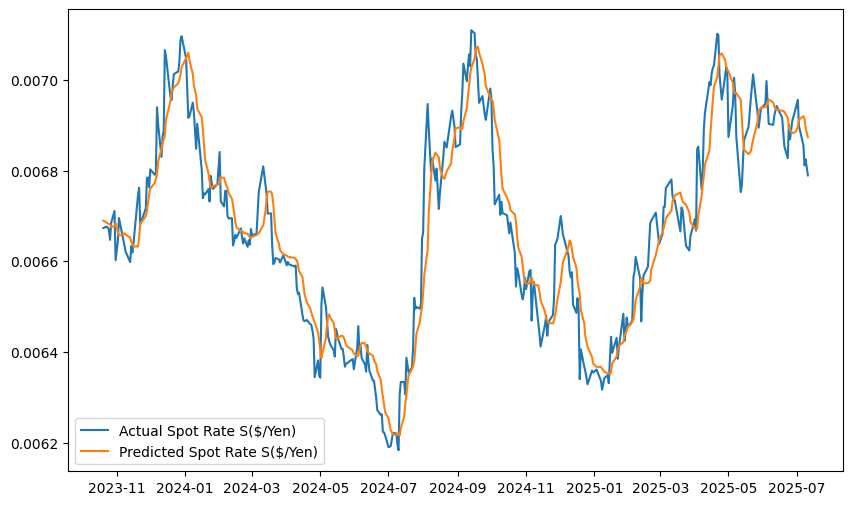

In [5]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/Yen)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/Yen)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate-usdyen.png")
plt.show()